<a href="https://colab.research.google.com/github/agus-fran-1998/BotTrading/blob/main/Trading_bot_24hrs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Configuración del Ambiente


In [1]:
# Importar librerías de manipulación de datos
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas del DataFrame
pd.set_option('display.expand_frame_repr', False)  # Evitar que el DataFrame se divida en varias líneas si tiene muchas columnas

# Importar librerías para manejo de tiempo y fecha
import time
from datetime import datetime, timedelta

# Importar librerías de scraping
import requests
from bs4 import BeautifulSoup

# Importar librerías de visualización
import matplotlib.pyplot as plt
plt.rc('figure', figsize = (5, 5))  # Establecer el tamaño predeterminado de las figuras a 5x5 pulgadas

# Importar librerías específicas de entorno Jupyter
from IPython.display import clear_output

# Importar librería para obtención de datos financieros
import yfinance as yf

# Variables globales
global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color


In [2]:
#Muestra versiones de las bibliotecas
# Verificar la versión de Python
!python --version

# Verificar la versión de pandas
!pip show pandas | grep Version

# Verificar la versión de numpy
!pip show numpy | grep Version

# Verificar la versión de matplotlib
!pip show matplotlib | grep Version



Python 3.11.11
Version: 2.2.2
Version: 1.26.4
Version 3.1, 31 March 2009
                       Version 3, 29 June 2007
  5. Conveying Modified Source Versions.
  14. Revised Versions of this License.
Version: 3.10.0


# 2. Obtención de datos

## 2.1 Precios Históricos del Bitcoin

In [3]:
def importar_base_bitcoin():
    global df_bitcoin
    end_data = datetime.now()
    start_data = end_data - timedelta(days=7)

    # Descargando datos de BTC usando Yahoo Finance
    df_bitcoin = yf.download("BTC-USD", start=start_data, end=end_data, interval="5m")

In [4]:
importar_base_bitcoin()
df_bitcoin.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Datetime,,,,,
2025-01-16 23:25:00+00:00,99844.359375,99864.742188,99844.359375,99864.742188,0
2025-01-16 23:30:00+00:00,99835.546875,99893.085938,99835.546875,99893.085938,0
2025-01-16 23:35:00+00:00,99948.195312,99948.195312,99863.703125,99867.335938,0
2025-01-16 23:40:00+00:00,100014.812500,100031.617188,100005.570312,100015.257812,0
2025-01-16 23:45:00+00:00,100014.765625,100090.000000,100014.765625,100090.000000,0


In [5]:
df_bitcoin.columns = ['_'.join(map(str, col)) if isinstance(col, tuple) else col for col in df_bitcoin.columns]
df_bitcoin.columns

Index(['Close_BTC-USD', 'High_BTC-USD', 'Low_BTC-USD', 'Open_BTC-USD',
       'Volume_BTC-USD'],
      dtype='object')

In [6]:
print(df_bitcoin.columns)
print(df_bitcoin.index)

Index(['Close_BTC-USD', 'High_BTC-USD', 'Low_BTC-USD', 'Open_BTC-USD',
       'Volume_BTC-USD'],
      dtype='object')
DatetimeIndex(['2025-01-16 23:25:00+00:00', '2025-01-16 23:30:00+00:00',
               '2025-01-16 23:35:00+00:00', '2025-01-16 23:40:00+00:00',
               '2025-01-16 23:45:00+00:00', '2025-01-16 23:50:00+00:00',
               '2025-01-16 23:55:00+00:00', '2025-01-17 00:00:00+00:00',
               '2025-01-17 00:05:00+00:00', '2025-01-17 00:10:00+00:00',
               ...
               '2025-01-23 22:35:00+00:00', '2025-01-23 22:40:00+00:00',
               '2025-01-23 22:45:00+00:00', '2025-01-23 22:50:00+00:00',
               '2025-01-23 22:55:00+00:00', '2025-01-23 23:00:00+00:00',
               '2025-01-23 23:05:00+00:00', '2025-01-23 23:10:00+00:00',
               '2025-01-23 23:15:00+00:00', '2025-01-23 23:20:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datetime', length=2016, freq=None)


## 2.2 Indicadores de Tendencias

# ATENCION
# Los selectores HTML pueden variar según las actualizaciones del sitio web, así que si el scraping no funciona
# revisen la estructura actualizada del HTML.

In [7]:
# VERSION 1


# def extraer_tendencias():
#     """
#     Extrae tendencias y toma decisiones de trading basadas en el análisis de precios de Bitcoin.

#     Esta función utiliza la biblioteca yfinance para obtener datos históricos de Bitcoin y BeautifulSoup
#     para scrapear el precio actual y la variación de precio de CoinMarketCap. Luego, calcula la media del
#     precio de cierre y establece una tendencia simple basada en la comparación de precios. Finalmente,
#     define un algoritmo de decisión basado en la tendencia y el precio actual.

#     Variables globales:
#     df_bitcoin (pandas.DataFrame): DataFrame que contiene los datos históricos de Bitcoin.
#     precio_actual (float): Precio actual de Bitcoin.
#     tendencia (str): Tendencia del mercado ("Alcista" o "Bajista").
#     media_bitcoin (float): Media del precio de cierre de Bitcoin.
#     algoritmo_decision (str): Decisión del algoritmo ("Comprar", "Vender" o "Esperar").
#     """


#     global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision
#     from bs4 import BeautifulSoup
#     import requests
# headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/118.0'}

# # URL de la página de CoinMarketCap
# url = "https://coinmarketcap.com/"
# # Realizar una solicitud GET a la URL
# response = requests.get(url, headers=headers)
# # Parsear el contenido de la página con BeautifulSoup
# soup = BeautifulSoup(response.content, features = 'lxml')


# # Buscar el elemento que contiene el precio actual del Bitcoin en USD
# bitcoin_price_element = soup.find('div', {'class': ['sc-b3fc6b7-0 dzgUIj rise','sc-b3fc6b7-0 dzgUIj','sc-b3fc6b7-0 dzgUIj fall']})
# bitcoin_1h_change_element = soup.find('span', {'class': ['sc-a59753b0-0 ivvJzO']})


# span_element = bitcoin_price_element.find('span')
# span_element2 = bitcoin_1h_change_element.find('span')

# variacion = span_element2.get('class')

# precio = span_element.text.strip()
# precio_actual = float(precio.replace('$', '').replace(',', ''))

# variacion = str(variacion)

# # Llama a la función para extraer las tendencias
# extraer_tendencias()

# if variacion == "['icon-Caret-up']":
#     tendencia = "Alcista"
# elif variacion == "['icon-Caret-down']":
#     tendencia = "Bajista"
# else:
#     tendencia = ""


# # Definir un algoritmo de decisión
#     if precio_actual > media_bitcoin and tendencia == "Bajista":
#         algoritmo_decision = "Comprar"
#     elif precio_actual < media_bitcoin and tendencia == "Alcista":
#         algoritmo_decision = "Vender"
#     else:
#         algoritmo_decision = "Esperar"

# # Imprime las variables globales
# print("********************")
# print("Precio Actual:", precio_actual)
# print("Tendencia:", tendencia)
# print("Media Bitcoin:", media_bitcoin)
# print("Algoritmo de Decisión:", algoritmo_decision)
# print("********************")



# VERSION 2
def extraer_tendencias():
    global precio_actual, tendencia, color
    global df_ethereum, df_ethereum_limpio, precio_actual, tendencia, media_ethereum, algoritmo_decision, color

    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'}
    url = 'https://coinmarketcap.com/currencies/bitcoin/'

    try:
        # Realizar la solicitud con los headers para evitar ser bloqueado
        respuesta = requests.get(url, headers=headers)
        respuesta.raise_for_status()
        s = BeautifulSoup(respuesta.content, 'html.parser')

        # 1. Extraer el precio actual del BTC
        precio_tag = s.find("span", {"data-test": "text-cdp-price-display"})

        if precio_tag:        #  class : [sc-65e7f566-0 esyGGG data-test="text-cdp-price-display"
            precio_actual = float(precio_tag.getText().replace('$', '').replace(',', ''))
        else:
            precio_actual = None

        # 2. Extraer la tendencia del precio (alta o baja)
        tendencia_tag = s.find("p", {"color": True, "data-change": True})
        if tendencia_tag:
            color = tendencia_tag['color']
            if color == "green":
                tendencia = "alta"
            elif color == "red":
                tendencia = "baja"
            else:
                tendencia = "estable"
        else:
            tendencia = None
            color = None

        return precio_actual, tendencia

    except Exception as e:
        print("Error al extraer datos:", e)


In [8]:
precio_actual, tendencia = extraer_tendencias()

In [9]:
extraer_tendencias()
print(f"Precio actual de Bitcoin: {precio_actual}")
print(f"Tendencia: {tendencia}")


Precio actual de Bitcoin: 104427.2
Tendencia: alta


# 3. Limpieza de datos

In [10]:
def limpieza_datos():
    # Definición de variables globales
    global df_bitcoin, df_bitcoin_limpio, media_bitcoin

    # Reiniciar los indices
    df_bitcoin.reset_index(inplace=True)

    # Guardar el número inicial de registros
    registros_iniciales = len(df_bitcoin)

    # Crear una copia del DataFrame original
    df_bitcoin_limpio = df_bitcoin.copy()

    # Eliminar registros con índice duplicado, manteniendo solo la primera aparición
    df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated(keep='first')]

    # Rellenar valores nulos en la columna 'close' con el último valor no nulo disponible
    df_bitcoin_limpio['Close_BTC-USD'].fillna(method='ffill', inplace=True)

    # Eliminar filas donde el valor en la columna 'volumen' sea menor o igual a cero
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio['Volume_BTC-USD'] > 0]

    # Calcular los cuartiles y el rango intercuartílico (IQR) para la columna 'close'
    q1 = df_bitcoin_limpio['Close_BTC-USD'].quantile(0.25)
    q3 = df_bitcoin_limpio['Close_BTC-USD'].quantile(0.75)
    iqr = q3 - q1
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    # Eliminar registros cuyo valor en la columna 'close' esté fuera de los límites definidos por el IQR
    df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio['Close_BTC-USD'] >= limite_inferior)
    & (df_bitcoin_limpio['Close_BTC-USD'] <= limite_superior)]

    # Calcular el precio promedio del BTK usando la columna 'close'
    media_bitcoin = df_bitcoin_limpio['Close_BTC-USD'].mean().round(4)

    # Guardar el número de registros después del proceso
    registros_finales = len(df_bitcoin_limpio)

    # Calcular la cantidad de registros eliminados
    registros_eliminados = registros_iniciales - registros_finales

    return {
        'registros_iniciales': registros_iniciales,
        'registros_finales': registros_finales,
        'registros_eliminados': registros_eliminados,
        'media_bitcoin': media_bitcoin
    }

limpieza_datos()

<ipython-input-10-cfcc2edec99f>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_bitcoin_limpio['Close_BTC-USD'].fillna(method='ffill', inplace=True)
<ipython-input-10-cfcc2edec99f>:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bitcoin_limpio['Close_BTC-USD'].fillna(method='ffill', inplace=True)


{'registros_iniciales': 2016,
 'registros_finales': 1050,
 'registros_eliminados': 966,
 'media_bitcoin': 103788.3365}

## 3.1 Exploración inicial de los datos de Bitcoin sin tratamiento

In [11]:
#Muestra informaciones de la base original, sin tratamiento
print(df_bitcoin.info())
df_bitcoin.describe().round(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Datetime        2016 non-null   datetime64[ns, UTC]
 1   Close_BTC-USD   2016 non-null   float64            
 2   High_BTC-USD    2016 non-null   float64            
 3   Low_BTC-USD     2016 non-null   float64            
 4   Open_BTC-USD    2016 non-null   float64            
 5   Volume_BTC-USD  2016 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(1)
memory usage: 94.6 KB
None


,Close_BTC-USD,High_BTC-USD,Low_BTC-USD,Open_BTC-USD,Volume_BTC-USD
count,2016.0,2016.0,2016.0,2016.0,2.016000e+03
mean,103943.0,104022.0,103856.0,103938.0,1.015275e+08
std,1719.0,1725.0,1719.0,1724.0,2.426439e+08
min,99722.0,99865.0,99623.0,99623.0,0.000000e+00
25%,102573.0,102646.0,102488.0,102579.0,0.000000e+00
50%,104095.0,104164.0,104022.0,104086.0,6.838272e+06
75%,104967.0,105014.0,104903.0,104970.0,1.006244e+08
max,108897.0,109110.0,108711.0,108900.0,3.901678e+09


## 3.2 Visualización de la distribución del Precio de Cierre sin tratamiento

<Axes: >

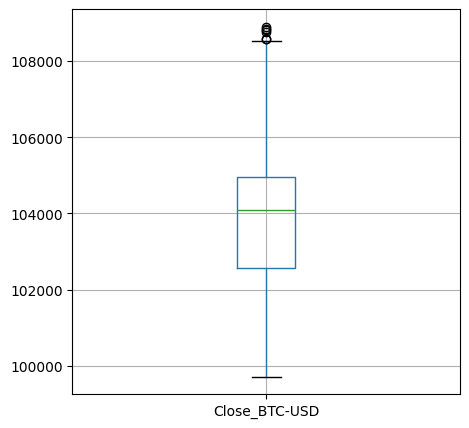

In [12]:
#Muestra el boxplot de la base sin tratamiento
df_bitcoin.boxplot(['Close_BTC-USD'])

## 3.3 Función para la limpieza de los datos de Bitcoin

In [13]:
# def limpieza_datos():
#     global df_bitcoin, df_bitcoin_limpio, media_bitcoin, precio_actual, tendencia

#     # Tu codigo aqui

## 3.4 Visualización de la distribución del Precio de Cierre después de la limpieza

<ipython-input-10-cfcc2edec99f>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_bitcoin_limpio['Close_BTC-USD'].fillna(method='ffill', inplace=True)
<ipython-input-10-cfcc2edec99f>:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bitcoin_limpio['Close_BTC-USD'].fillna(method='ffill', inplace=True)


<Axes: >

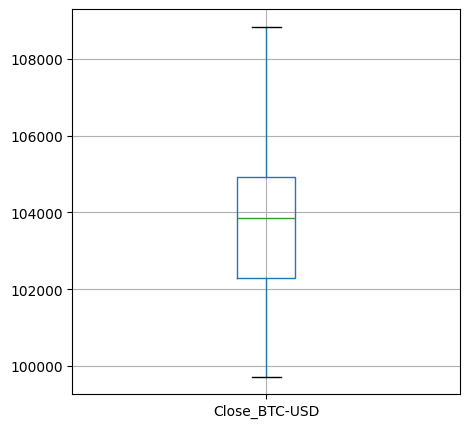

In [14]:
limpieza_datos()
#Muestra el Boxplot de la base limpia

df_bitcoin_limpio.boxplot(['Close_BTC-USD'])

## 3.5 Comparación de la distribución del Precio de Cierre antes y después de la limpieza

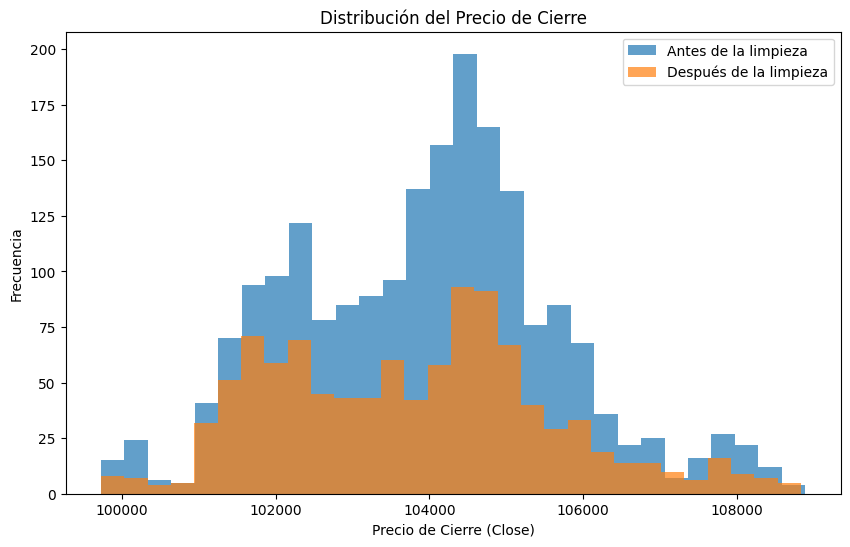

In [15]:
#@title Gráfico de distribución del Precio de Cierre antes y después de la limpieza { display-mode: "form" }
# Gráfico de antes y después de la limpieza de la distribución del Precio de Cierre
plt.figure(figsize=(10, 6))
plt.hist(df_bitcoin['Close_BTC-USD'], bins=30, alpha=0.7, label='Antes de la limpieza')
plt.hist(df_bitcoin_limpio['Close_BTC-USD'], bins=30, alpha=0.7, label='Después de la limpieza')
plt.legend()
plt.title('Distribución del Precio de Cierre')
plt.xlabel('Precio de Cierre (Close)')
plt.ylabel('Frecuencia')
plt.show()

# 4. Tomar decisiones

## 4.1 Encontrar medias moviles

In [16]:
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 26 to 2015
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   index           1050 non-null   int64              
 1   Datetime        1050 non-null   datetime64[ns, UTC]
 2   Close_BTC-USD   1050 non-null   float64            
 3   High_BTC-USD    1050 non-null   float64            
 4   Low_BTC-USD     1050 non-null   float64            
 5   Open_BTC-USD    1050 non-null   float64            
 6   Volume_BTC-USD  1050 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(4), int64(2)
memory usage: 65.6 KB


In [17]:
def calcular_sma():
    global df_bitcoin_limpio

    # Calcular la SMA de corto plazo (10 periodos)
    df_bitcoin_limpio['SMA_corto'] = df_bitcoin_limpio['Close_BTC-USD'].rolling(window=10).mean()

    # Calcular la SMA de largo plazo (50 periodos)
    df_bitcoin_limpio['SMA_largo'] = df_bitcoin_limpio['Close_BTC-USD'].rolling(window=50).mean()

calcular_sma()


In [18]:
print(df_bitcoin_limpio.head())

    index                  Datetime  Close_BTC-USD   High_BTC-USD    Low_BTC-USD   Open_BTC-USD  Volume_BTC-USD  SMA_corto  SMA_largo
26     26 2025-01-17 01:35:00+00:00  101022.734375  101022.734375  100514.117188  100514.117188       377057280        NaN        NaN
27     27 2025-01-17 01:40:00+00:00  101445.421875  101474.679688  101106.906250  101106.906250       596115456        NaN        NaN
28     28 2025-01-17 01:45:00+00:00  101329.656250  101726.906250  101329.656250  101586.375000       781766656        NaN        NaN
29     29 2025-01-17 01:50:00+00:00  101400.445312  101467.343750  101254.656250  101254.656250       614141952        NaN        NaN
30     30 2025-01-17 01:55:00+00:00  101656.500000  101660.937500  101467.523438  101467.523438       310140928        NaN        NaN


In [19]:
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 26 to 2015
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   index           1050 non-null   int64              
 1   Datetime        1050 non-null   datetime64[ns, UTC]
 2   Close_BTC-USD   1050 non-null   float64            
 3   High_BTC-USD    1050 non-null   float64            
 4   Low_BTC-USD     1050 non-null   float64            
 5   Open_BTC-USD    1050 non-null   float64            
 6   Volume_BTC-USD  1050 non-null   int64              
 7   SMA_corto       1041 non-null   float64            
 8   SMA_largo       1001 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 82.0 KB


## 4.2 Evaluar datos y tomar decision

In [20]:
# # Función para tomar decisiones basadas en SMA y tendencia del mercado
# def tomar_decisiones(df_bitcoin_limpio):
#     global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color

#     # Obtener los valores más recientes de SMA corta y SMA larga
#     SMA_corto = df_bitcoin_limpio['SMA_corto'].iloc[-1]
#     SMA_largo = df_bitcoin_limpio['SMA_largo'].iloc[-1]

#     # Decidir según las condiciones definidas
#     if SMA_corto > SMA_largo and tendencia == "Alta":
#         algoritmo_decision = "Comprar"
#         color = "#00FF00"  # Color verde para la compra
#     elif SMA_corto < SMA_largo and tendencia == "Baja":
#         algoritmo_decision = "Vender"
#         color = "#FF0000"  # Color rojo para la venta
#     else:
#         algoritmo_decision = "Mantener"
#         color = "#000000"  # Color negro para mantener

#     # Imprimir los resultados
#     print(f"Precio actual: {precio_actual}")
#     print(f"SMA Corta: {SMA_corto}")
#     print(f"SMA Larga: {SMA_largo}")
#     print(f"Tendencia del mercado: {tendencia}")
#     print(f"Decisión del algoritmo: {algoritmo_decision}")
#     print(f"Color de la señal: {color}")

# tomar_decisiones(df_bitcoin_limpio)



# Función para tomar decisiones basadas en SMA y tendencia del mercado
def tomar_decisiones(df_bitcoin_limpio):
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, color

    # Obtener los valores más recientes de SMA_corto y SMA_largo
    SMA_corto = df_bitcoin_limpio['SMA_corto'].iloc[-1]
    SMA_largo = df_bitcoin_limpio['SMA_largo'].iloc[-1]

    # Decidir según las condiciones definidas
    if SMA_corto > SMA_largo and tendencia == "Alta":
        algoritmo_decision = "Comprar"
        color = "#00FF00"  # Color verde para la compra
    elif SMA_corto < SMA_largo and tendencia == "Baja":
        algoritmo_decision = "Vender"
        color = "#FF0000"  # Color rojo para la venta
    else:
        algoritmo_decision = "Mantener"
        color = "#000000"  # Color negro para mantener

    # Imprimir los resultados
    print(f"Precio actual: {precio_actual}")
    print(f"SMA Corto: {SMA_corto}")
    print(f"SMA Largo: {SMA_largo}")
    print(f"Tendencia del mercado: {tendencia}")
    print(f"Decisión del algoritmo: {algoritmo_decision}")
    print(f"Color de la señal: {color}")
tomar_decisiones(df_bitcoin_limpio)

Precio actual: 104427.2
SMA Corto: 104170.3390625
SMA Largo: 104002.178125
Tendencia del mercado: alta
Decisión del algoritmo: Mantener
Color de la señal: #000000


# ATENCION
# Recuerden que la tendencia de una hora puede cambiar rápidamente.
# Siempre revisen las señales de color en el gráfico antes de tomar decisiones.

#  5. Visualizaciones

## 5.1 Función para graficar tendencias

In [21]:
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 26 to 2015
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   index           1050 non-null   int64              
 1   Datetime        1050 non-null   datetime64[ns, UTC]
 2   Close_BTC-USD   1050 non-null   float64            
 3   High_BTC-USD    1050 non-null   float64            
 4   Low_BTC-USD     1050 non-null   float64            
 5   Open_BTC-USD    1050 non-null   float64            
 6   Volume_BTC-USD  1050 non-null   int64              
 7   SMA_corto       1041 non-null   float64            
 8   SMA_largo       1001 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 82.0 KB


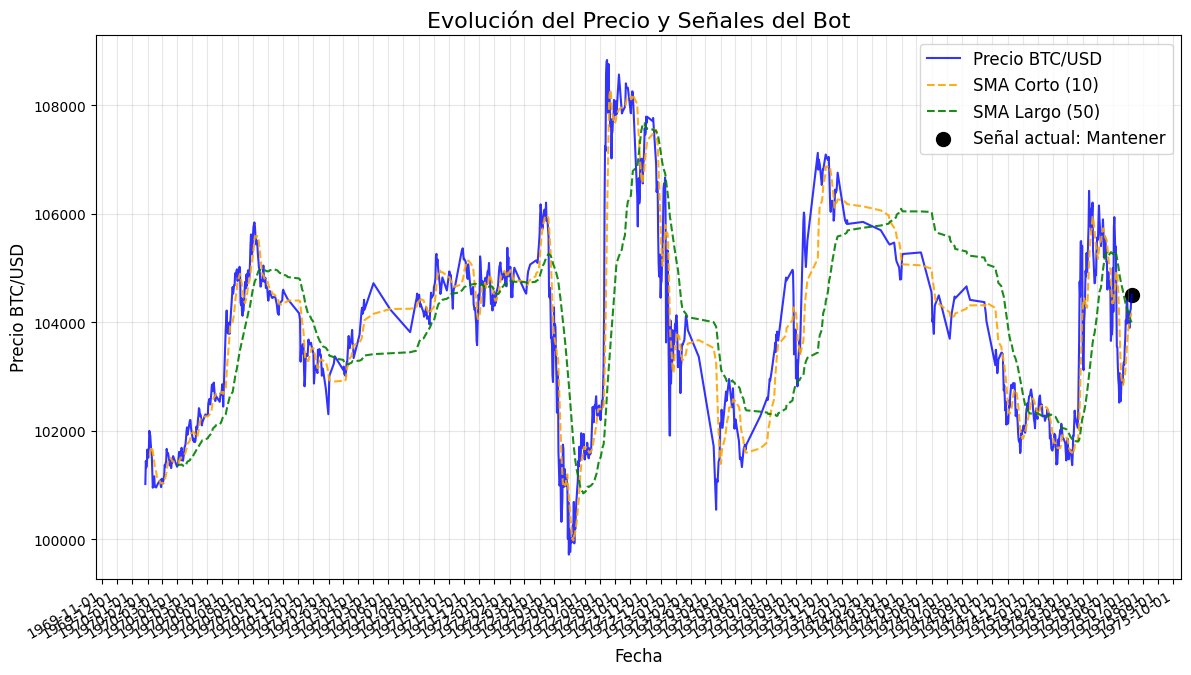

In [22]:
import matplotlib.dates as mdates

def new_signal_graph(df_bitcoin_limpio, algoritmo_decision, color):
    """
    Genera un gráfico con la evolución del precio de la moneda, medias móviles,
    y las señales de compra o venta más recientes.

    Args:
        df_bitcoin_limpio (DataFrame): DataFrame con las columnas 'Close_BTC-USD', 'SMA_corto', 'SMA_largo'.
        algoritmo_decision (str): Decisión del bot ("Comprar", "Vender" o "Mantener").
        color (str): Color de la señal de decisión actual.
    """

    # Configurar el tamaño del gráfico
    plt.figure(figsize=(14, 8))

    # Graficar el precio de cierre
    plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['Close_BTC-USD'], label='Precio BTC/USD', color='blue', alpha=0.8)

    # Graficar las medias móviles
    plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['SMA_corto'], label='SMA Corto (10)', color='orange', linestyle='--', alpha=0.9)
    plt.plot(df_bitcoin_limpio.index, df_bitcoin_limpio['SMA_largo'], label='SMA Largo (50)', color='green', linestyle='--', alpha=0.9)

    # Agregar la señal de compra o venta más reciente
    ultima_senal = df_bitcoin_limpio.iloc[-1]
    plt.scatter(ultima_senal.name, ultima_senal['Close_BTC-USD'], color=color, s=100, label=f'Señal actual: {algoritmo_decision}', edgecolors='k')

    # Formato del eje X (fechas)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()

    # Configurar título y etiquetas
    plt.title('Evolución del Precio y Señales del Bot', fontsize=16)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Precio BTC/USD', fontsize=12)

    # Agregar leyenda
    plt.legend(fontsize=12)

    # Mostrar el gráfico
    plt.grid(alpha=0.3)
    plt.show()

new_signal_graph(df_bitcoin_limpio, algoritmo_decision, color)

# 6. Ciclo

In [23]:
# Aplanar las columnas del DataFrame original
df_bitcoin_limpio = aplanar_columnas_df(df_bitcoin_limpio)

# Verificar las columnas
print(df_bitcoin_limpio.columns)

# Iniciar el bucle
while True:
    print("Iniciando ciclo de análisis...")

    # Paso 1: Descargar los datos y extraer el precio actual
    importar_base_bitcoin()
    extraer_tendencias()

    # Paso 2: Limpiar los datos y calcular las medias móviles
    limpieza_datos()
    calcular_sma(df_bitcoin_limpio)

    # Paso 3: Tomar la decisión de compra/venta
    tomar_decisiones(df_bitcoin_limpio)

    # Paso 4: Graficar las tendencias y señales
    new_signal_graph(df_bitcoin_limpio, algoritmo_decision, color)

    # Esperar 5 minutos antes de la siguiente decisión
    print("Esperando 5 minutos antes de la siguiente decisión...")
    time.sleep(300)


NameError: name 'aplanar_columnas_df' is not defined

In [24]:
df_bitcoin_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 26 to 2015
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   index           1050 non-null   int64              
 1   Datetime        1050 non-null   datetime64[ns, UTC]
 2   Close_BTC-USD   1050 non-null   float64            
 3   High_BTC-USD    1050 non-null   float64            
 4   Low_BTC-USD     1050 non-null   float64            
 5   Open_BTC-USD    1050 non-null   float64            
 6   Volume_BTC-USD  1050 non-null   int64              
 7   SMA_corto       1041 non-null   float64            
 8   SMA_largo       1001 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 82.0 KB


In [ ]:
df_bitcoin_limpio.describe()